# Suggestion to indoor thermal comfort strategy
This project aims to apply the psychrometric chart to achieve indoor thermal comfort control.

### Import packages

In [1]:
#%% Import packages
import pandas as pd
import numpy as np
import sqlite3
import plotly.graph_objects as go
from scipy.optimize import minimize
import matplotlib.pyplot as plt

### Import data
Using the office dataset with estimated building temperature and MRT.

In [2]:
path = r'C:\Users\Jacky\Jupyter Projects\Office_Data'
df = pd.read_excel(path+r'\Office_k_MRT.xlsx')
df

,Time,T_in,RH,T_out,Occ,HRV,DoW,T_bdg_pred,MRT
0,2020-07-01 00:00:00,30.2,88.0,28.4,0,0.0,3,28.400000,28.400000
1,2020-07-01 00:30:00,30.3,88.7,28.3,0,0.0,3,28.390000,28.390000
2,2020-07-01 01:00:00,30.3,88.8,28.1,0,0.0,3,28.361000,28.361000
3,2020-07-01 01:30:00,30.3,89.5,28.0,0,0.0,3,28.324900,28.324900
4,2020-07-01 02:00:00,30.4,90.4,27.9,0,0.0,3,28.282410,28.282410
...,...,...,...,...,...,...,...,...,...
4411,2020-09-30 21:30:00,26.7,92.8,22.3,0,0.0,3,24.750387,24.750387
4412,2020-09-30 22:00:00,26.7,93.0,22.4,0,0.0,3,24.515349,24.515349
4413,2020-09-30 22:30:00,26.6,92.1,22.6,0,0.0,3,24.323814,24.323814
4414,2020-09-30 23:00:00,26.5,92.9,22.6,0,0.0,3,24.151432,24.151432


### Import thefunction of psychrometric chart 
The following code mostly refers to the study of Teitelbaum et al.[1].<br>

Some of the parameters are adjusted to match the real conditions within the office data.<br>

Also, the local climate feature and residents' adaption in Taiwan are considered as well.

The original annotations are in the symbol: #<br>
while the additional ones are in the symbol: ##

In [3]:
def psychart(
    algorithm = "solving for mrt with forced convection",

    # air temperature range over which calculations are performed [oC]
    temp_air_init = np.arange(10, 35, .5),

    # RH range over which calculations are performed [%]
    RH_psy_init = np.arange(0,100,1)/100,

    # metabolic rate for a person set to 1.2 [met]
    ## the office work in this case is arround 1.0-1.2
    MR = 1.0,

    # skin wettedness parameter, [unitless]
    # 0.06 for dry skin, accounts for diffusion through skin; 0.8 is the practical upper bound for very sweaty skin
    ## set skin wettedness as 0.15 because of the humid weather in Taiwan (RH always around 60-70%) 
    w = 0.15,

    # air speed in [m/s]
    ## the ventilation device operating constantly
    v = .15,

    # the air temperature minus MRT [K]; this is specified to calculate a wind speed for thermal comfort
    # values > 0 are for an air temperature greater than the MRT
    dep = 0,

    # emissivity of human skin [unitless]; values in the literature vary between 0.95 to 0.98
    E = 0.98):

    # convert to [W/m2]
    MR= MR*58.1666666

    # Stephan Botlztmans constant
    o = 0.00000005670367

    # empirical ratio for a seated person
    Ar_Ad = 0.7

    # empirical ratio for calculating the evaporative "heat transfer" coefficient
    LR = 16.5

    # define psychrometric temp bounds for drawing %RH lines
    temperature = np.arange(5, 35, 0.1)

    # redefine temp and %RH arrays
    temp_air = np.tile(np.array(temp_air_init),(len(RH_psy_init),1)).transpose()
    RH_psy = np.tile(np.array(RH_psy_init),(len(temp_air_init),1))

    # 2D relative humidity array dimension constant & 2D air temperature array dimension constant
    dim1 = len(RH_psy)
    dim2 = len(temp_air)

    # for an arbitrary fixed comfort zone box calculation
    # BL = Bottom Left ...
    ## Note: the original guess of the comfort range (Ta: 21-27) is resonable for indoor comfort control in Taiwan 
    BL = 0.3*1000*0.62198*np.exp(77.345+0.0057*(21+273.15)-7235/(21+273.15))/(101325*np.power((21+273.15),8.2)-np.exp(77.345+0.0057*(21+273.15)-7235/(21+273.15)))
    TL = 0.6*1000*0.62198*np.exp(77.345+0.0057*(21+273.15)-7235/(21+273.15))/(101325*np.power((21+273.15),8.2)-np.exp(77.345+0.0057*(21+273.15)-7235/(21+273.15)))
    BR = 0.3*1000*0.62198*np.exp(77.345+0.0057*(27+273.15)-7235/(27+273.15))/(101325*np.power((27+273.15),8.2)-np.exp(77.345+0.0057*(27+273.15)-7235/(27+273.15)))
    TR = 0.6*1000*0.62198*np.exp(77.345+0.0057*(27+273.15)-7235/(27+273.15))/(101325*np.power((27+273.15),8.2)-np.exp(77.345+0.0057*(27+273.15)-7235/(27+273.15)))
    comfort = np.arange(21, 27, 0.1)

    # ARRAY DECLARATIONS AND CALCULATIONS

    # skin temp calculation
    temp_skin = temp_air*.3812+22.406

    # vapor pressure of water on skin's surface
    P_sat_skin_psy = np.power(2.718,(77.3450+0.0057*(temp_skin+273.15)-7235/(temp_skin+273.15)))/(np.power((temp_skin+273.15),8.2))/1000

    # mapping %RH matrix to specific humidity for plotting
    psy_sat = np.zeros((dim2, dim1))
    psy_sat = 1000*0.62198*np.exp(77.345+0.0057*(temp_air+273.15)-7235/(temp_air+273.15))/(101325*np.power((temp_air+273.15),8.2)-np.exp(77.345+0.0057*(temp_air+273.15)-7235/(temp_air+273.15)))*RH_psy

    # vapor pressure of water in air
    P_sat_air_psy = np.zeros((dim2, dim1))
    P_sat_air_psy = np.power(2.718,(77.3450+0.0057*(temp_air+273.15)-7235/(temp_air+273.15)))/(np.power((temp_air+273.15),8.2))/1000*RH_psy

    # free convection heat transfer coefficient for seated person
    h_c_free_psy = 0.78*np.power(np.absolute(temp_skin-temp_air),0.56)

    # free convection around the human body
    Q_conv_free_psy = np.zeros((dim2, dim1))
    Q_conv_free_psy = h_c_free_psy*(temp_skin-temp_air)

    # free convection evaporative heat transfer coefficient
    h_e_free_psy = h_c_free_psy*LR

    # associated evaporative "heat transfer" about the human body (free convection)
    Q_evap_free_psy = np.zeros((dim2, dim1))
    Q_evap_free_psy = h_e_free_psy*w*(P_sat_skin_psy-P_sat_air_psy)

    # solved mean radiant temperature required for thermal comfort taking free convection into account
    T_MRT_psy = np.zeros((dim2, dim1))
    T_MRT_psy = np.power(np.power((temp_skin+273.15),4)-((MR-Q_evap_free_psy-Q_conv_free_psy)/E/o/Ar_Ad),0.25)-273.15
    
    ## set the figure and meshgrids for MRT contour
    plt.figure(figsize=(15,10))
    X,Y = np.meshgrid(RH_psy_init, temp_air_init)

    # set text size
    textsize = 14
    
    ## calculate Humidity Ratio varying over temp.
    saturation = 1000*0.62198*np.exp(77.345+0.0057*(temperature+273.15)-7235/(temperature+273.15))/(101325*np.power((temperature+273.15),8.2)-np.exp(77.345+0.0057*(temperature+273.15)-7235/(temperature+273.15)))

    ## set and plot level lines for RH(%) 
    ## Here use for-loop to shrink the code
    for i in range(1,10):
        plt.plot(temperature, saturation*.1*i, 'k-', linewidth = 1 , alpha = 0.5)
    plt.plot(temperature, saturation, 'k-', linewidth = 1, alpha = 1)
    plt.plot(temperature, saturation*RH_expl[1]*.01, 'k-.', linewidth = 1,alpha = 0.6)

    # solve for mrt with free convection
    ## this case consider only free convection method for brief application
    if v < 0.2:
        levels_contour = np.linspace(np.amin(T_MRT_psy), np.amax(T_MRT_psy), 15)
        ## filling contour
        CS3=plt.contourf(Y, psy_sat, T_MRT_psy, cmap = 'jet', levels=levels_contour, alpha = 0.6)
        ## contour line
        CS = plt.contour(Y, psy_sat, T_MRT_psy, 13, colors='k', alpha = 1)
        ## set contour labels, colorbar, and title of cbar
        plt.clabel(CS, inline=3, fmt='%1.1f', fontsize=textsize)
        cbar = plt.colorbar(CS3, orientation='vertical', format="%.1f")
        plt.text(38,-1.75,"MRT $^\circ$C", size=textsize)
    
    ## set and plot labels of RH(%)
    ## Here use for-loop to shrink the code
    text_x, text_y = [35.5]*10, [3.2, 6.8, 10.5, 14.1, 18, 21.5, 25.2, 29, 32.5, 36.2] 
    text_values = [str(i*10)+'%' for i in range(1, 11)]
    for i in range(10):
        plt.text(text_x[i], text_y[i], text_values[i], size=textsize)

    plt.xlabel("Air Temperature $^\circ$C", size=textsize)
    plt.ylabel("Humidity Ratio (g water/kg dry air)",size=textsize)

    return [temperature, saturation]

### Select an example from the office dataset
The selected data will be plotted on the chart for discussion.

In [5]:
# choose a weekday noon as example
expl = pd.DataFrame(data=df.iloc[2999:3002])
expl.reset_index(inplace=True, drop=True)

# prepare the elements for plot
Ta_expl = expl['T_in'].values
RH_expl = expl['RH'].values
ro = 0.61078*np.exp((17.27*Ta_expl)/(Ta_expl+237.3))*0.105
HRatio = RH_expl*0.622*ro/1013*1000
expl['HRatio'] = HRatio
expl

,Time,T_in,RH,T_out,Occ,HRV,DoW,T_bdg_pred,MRT,HRatio
0,2020-09-01 11:30:00,24.9,58.4,30.4,3,0.15,2,26.844658,28.276612,11.855932
1,2020-09-01 12:00:00,27.5,57.2,30.9,4,0.15,2,27.512329,27.521411,13.538433
2,2020-09-01 12:30:00,26.6,57.1,31.5,3,0.15,2,27.637397,28.397819,12.819943


Plot the psychrometric chart with the example.

,Time,T_in,RH,T_out,Occ,HRV,DoW,T_bdg_pred,MRT,HRatio
1,2020-09-01 12:00:00,27.5,57.2,30.9,4,0.15,2,27.512329,27.521411,13.538433


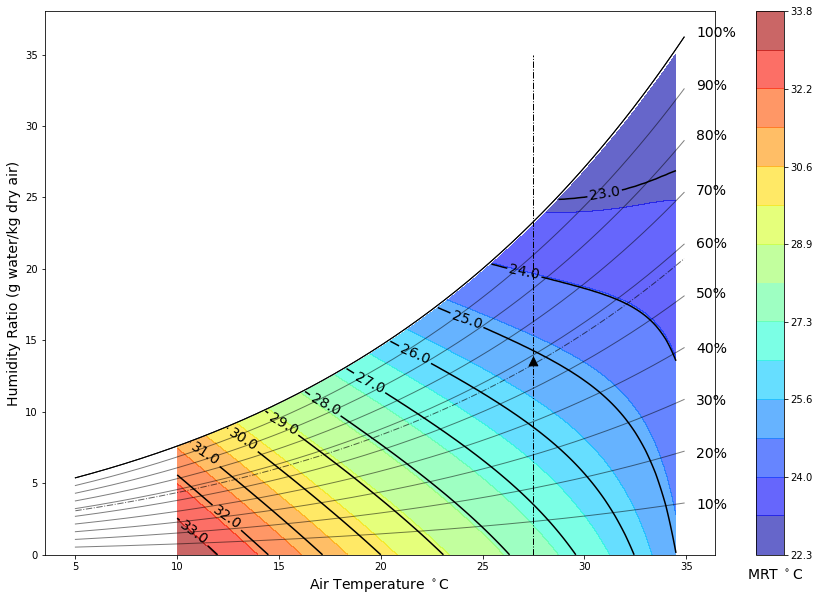

In [6]:
# plot the chart first
psycht = psychart()
plt.plot(psycht[0], psycht[1], 'k-', linewidth=1, alpha=1)

# plot the data at 12pm
Ta_12 = expl['T_in'][1]
HRatio_12 = expl['HRatio'][1]
plt.plot([Ta_12, Ta_12], [0, 35], 'k-.', linewidth=1, alpha=1)
plt.scatter(Ta_12, HRatio_12, s=75, c='black', marker='^', linewidth=1, alpha=1)
# print the example
expl[1:2]

### Comfort control suggestion
We can see the T_in and MRT of office data do not match the comfort zone of the chart.<bar>

Where the MRT should decline to around 25 degrees if the air temperature is constant;<br>

Or the air temperature should decline to around 21 degrees if the MRT is constant.<br>

So, here tries to present some potential strategies to achieve the comfort zone below.

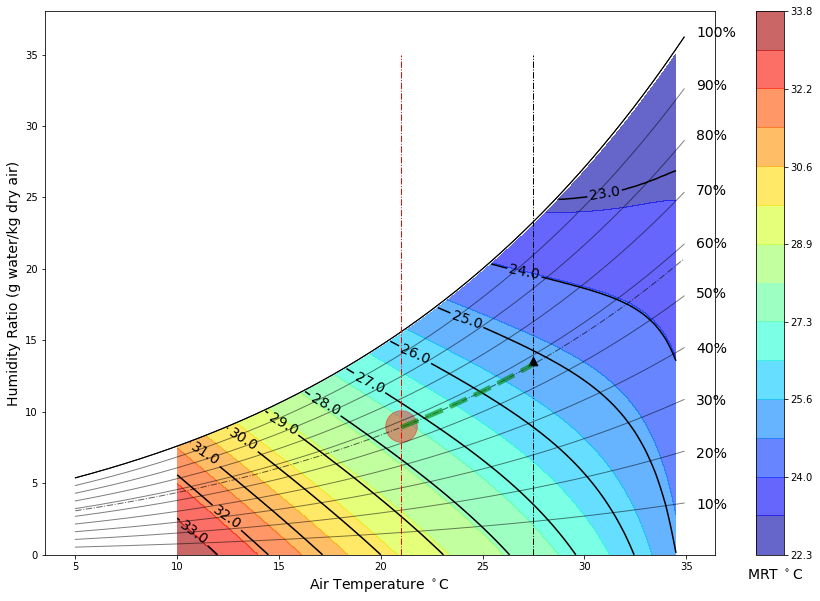

In [7]:
# plot the chart first
psycht = psychart()
plt.plot(psycht[0], psycht[1], 'k-', linewidth=1, alpha=1)

# plot the data at 12pm
Ta_12 = expl['T_in'][1]
HRatio_12 = expl['HRatio'][1]
plt.plot([Ta_12, Ta_12], [0, 35], 'k-.', linewidth=1, alpha=1)
plt.scatter(Ta_12, HRatio_12, s=75, c='black', marker='^', linewidth=1, alpha=1)

# solutions for thermal comfort
plt.scatter(21, 9, s=1000, c='red', marker='o', linewidth=1, alpha=0.4)
plt.plot([21, 21], [0, 35], 'r-.', linewidth=1, alpha=1)
tt = np.arange(21,27.5,0.1)
ss = 1000*0.62198*np.exp(77.345+0.0057*(tt+273.15)-7235/(tt+273.15))/(101325*np.power((tt+273.15),8.2)-np.exp(77.345+0.0057*(tt+273.15)-7235/(tt+273.15)))
plt.plot(tt, ss*RH_expl[1]*.01, 'g--', linewidth = 5,alpha = 0.6)

In the real case, the RH and MRT will slightly change if T<sub>in</sub> is adjusted, so the real comfort point may be on slightly right of the current one.

However, we can assume that the RH and MRT will not change drastically and can adjust T<sub>in</sub> by air conditioning for comfort control.<br>

Then the thermal condition of the office can approach the potential comfort point along the green dash line.<br>


#### **Note: The code of the psychrometric chart could refer to the reference below for further investigation.

## Reference
[1]

E. Teitelbaum, P. Jayathissa, C. Miller, F. Meggers, Design with Comfort: Expanding the psychrometric chart with radiation
and convection dimensions. Energy and Buildings 209, 10 (2020).

https://github.com/buds-lab/psychrometric-chart-makeover